# Set up

## Google Drive Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
# import .py for smooth tiled operation
!cp /content/drive/MyDrive/GA_capstone/Code/smooth_tiled_predictions.py /content

In [3]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 32.8 MB/s 


In [4]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
from PIL import Image
import pathlib

from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
import albumentations as A
import rasterio

from smooth_tiled_predictions import predict_img_with_smooth_windowing

## Import Prediction Images

In [5]:
# Set current working directory to the project folder in gdrive
root_dir = os.getcwd()
project_dir = root_dir + "/drive/My Drive/GA_capstone/"

In [6]:
# Import Image Folder
prediction_dir = project_dir + "Dataset/prediction/"
img_names = os.listdir(prediction_dir)

## Import Model

In [7]:
# import selected model
model = keras.models.load_model(project_dir + 'models/model_checkpoint/unet.keras', compile = False)

# Prediction

In [8]:
# define some parameters
patch_size = 256
n_classes = 5

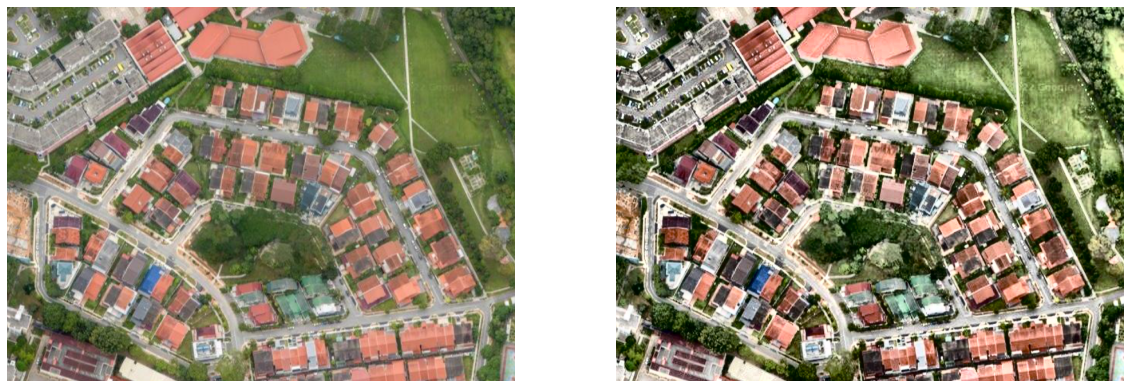

In [13]:
# Visualize the processing using histogram equalizer
for img_name in img_names:
  img = cv2.imread(prediction_dir + img_name,)
  
  transform_bc = A.Compose([
                            A.CLAHE (clip_limit=6, tile_grid_size=(8, 8), always_apply=False, p=1)
                            ])
  transformed = transform_bc(image=img)
  image_t1 = transformed['image']

  plt.figure(figsize = (20, 10))
  plt.subplot(1,2,1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(cv2.cvtColor(image_t1, cv2.COLOR_BGR2RGB))
  plt.axis('off')

In [15]:
# Prediction by splitting and merging tiles
for img_name in img_names:
  img = cv2.imread(prediction_dir + img_name,)
  #img = keras.utils.load_img(prediction_dir + img_name)
  #img = np.array(img)
  
  #plt.figure(figsize = (5, 5))
  #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  
  transform_bc = A.Compose([
                            A.CLAHE (clip_limit=6, tile_grid_size=(8, 8), always_apply=False, p=1)
                            ])
  transformed = transform_bc(image=img)
  image_t1 = transformed['image']

  predictions_smooth = predict_img_with_smooth_windowing(
    image_t1,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
    )


  final_prediction = np.argmax(predictions_smooth, axis=2)


100%|██████████| 8/8 [01:17<00:00,  9.67s/it]


## Calculate area

In [16]:
# Read the image with rasterio
image_r = rasterio.open(prediction_dir + img_name)
# Get area 
raster_area = (image_r.bounds.right - image_r.bounds.left) * (image_r.bounds.top - image_r.bounds.bottom)
# Calculate area of each class 
#  building (1), woodland (2), water(3), road(4)
class_map = {0: "Unlabelled", 1: 'Building', 2: 'Woodland', 3: 'Water', 4: 'Road'}
class_counts = np.unique(final_prediction, return_counts = True)
area_map = {class_map[v]: f"{str(round((class_counts[1][i]/class_counts[1].sum())*raster_area/1000000, 4))} sq.km" for i, v in enumerate(class_counts[0])}

## Display prediction with area

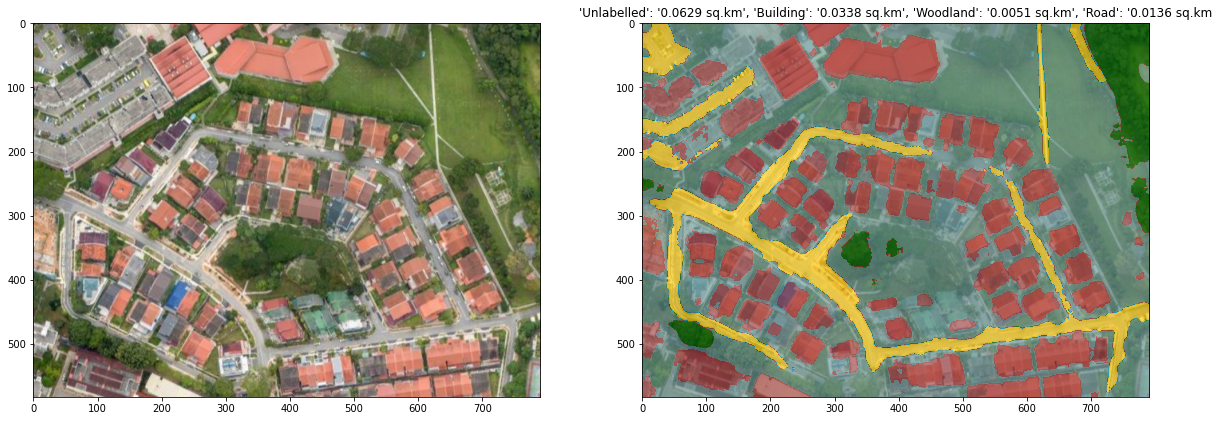

In [17]:
# Make colormap
# unlablled, building, woodlands, water, road

colors = [(102, 153, 153), (153, 51, 51), (0, 102, 0), (0, 153, 204), (255, 204, 0)]
colors = [tuple([num/255 for num in tup]) for tup in colors]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=5)


plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(final_prediction, vmin=0, vmax=4, alpha = 0.6, cmap = custom_cmap)
plt.title(str(area_map)[1:-2]);
plt.savefig(prediction_dir + 'predicted.jpg', bbox_inches='tight', pad_inches=0)